In [168]:
import numpy as np
import matplotlib.pyplot as plt

In [242]:
from scipy.stats import poisson, norm

def compute_sum_poisson_gaussian(amplitudes, A, mu, delta, sigma, Egamma):
    """
    Compute the sum over n of P(n; µ)·G(OFF; nEγ + delta; σ)
    
    Parameters:
    - amplitudes: Array of measured amplitudes (OFF).
    - N: Maximum number of photons to consider.
    - mu: Mean of the Poisson distribution.
    - delta: Offset for the Gaussian distribution.
    - sigma: Standard deviation of the Gaussian distribution.
    - Egamma: Energy of a single photon.
    
    Returns:
    - Array of computed values for the given amplitudes.
    """
    # Initialize result array
    result = np.zeros_like(amplitudes)

    N = 20
    
    # Array of possible photon numbers
    photon_numbers = np.arange(0, N+1, dtype=int)
    
    # Compute Poisson probabilities for all photon numbers
    poisson_probs = poisson.pmf(photon_numbers, mu)
    
    # Compute the Gaussian PDF for each photon number and sum up
    for i, n in enumerate(photon_numbers):
        # Compute Gaussian PDF for the current number of photons
        gaussian_values = norm.pdf(amplitudes, loc=n * Egamma + delta, scale=sigma)
        
        # Update result array
        result += poisson_probs[i] * gaussian_values
    
    return A * result

In [264]:
OFF = np.genfromtxt(r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\OPTIMUM\TXT\OFF_Tension.txt')
idx = OFF > 0.001
OFF = OFF[idx]

In [315]:
#<ValueView A=0.05864816449546586 mu=4.310964401360185 delta=0.001169559309161904 sigma=3e-05 Egamma=7.743099209858549e-05>
p0 = [0.06, 4, 0.00115, 3e-05, 8.299999999999996e-05]

In [316]:
# Define a range of amplitude values from 0 to 150
amplitude_range = np.linspace(min(OFF), max(OFF), 3908)

# Compute the PDF using the sum of Poisson and Gaussian
pdf_values = compute_sum_poisson_gaussian(amplitude_range, *p0)

# Normalize the PDF to create a probability distribution
pdf_values /= np.sum(pdf_values)  # Ensure it sums to 1

# Sample random amplitudes based on the computed distribution
n_samples = 3908  # Number of random samples to generate
random_amplitudes = np.random.choice(amplitude_range, size=n_samples, p=pdf_values)


In [317]:
hist, bin_edges = np.histogram(random_amplitudes, bins=80, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

real, bin_edges_real = np.histogram(OFF, bins=80, density=False)
bin_centers_real = (bin_edges_real[:-1] + bin_edges_real[1:]) / 2

In [323]:
error = np.ones(hist.shape[0])*0.0008855764274782089

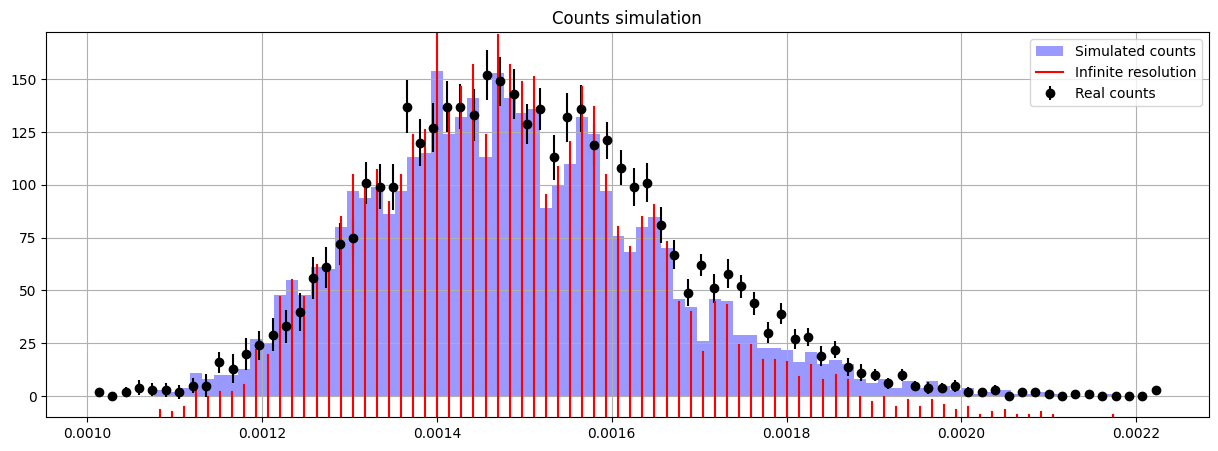

In [343]:
fig = plt.figure(figsize=(15,5))
fig.tight_layout()
plt.errorbar(bin_centers_real,real,np.sqrt(hist+1),fmt='ko',label='Real counts')
plt.hist(random_amplitudes, bins=80, density=False, alpha=0.4, color='blue', label='Simulated counts',histtype='stepfilled')
for bin,count in zip(bin_centers,hist):
    plt.axvline(bin,0,count/max(hist),color='red')
plt.axvline(bin,0,count/max(hist),color='red',label='Infinite resolution')
plt.legend()
plt.title('Counts simulation')
plt.grid()

In [416]:
final_error = np.sqrt(1/len(real)*np.sum((real-hist)**2))

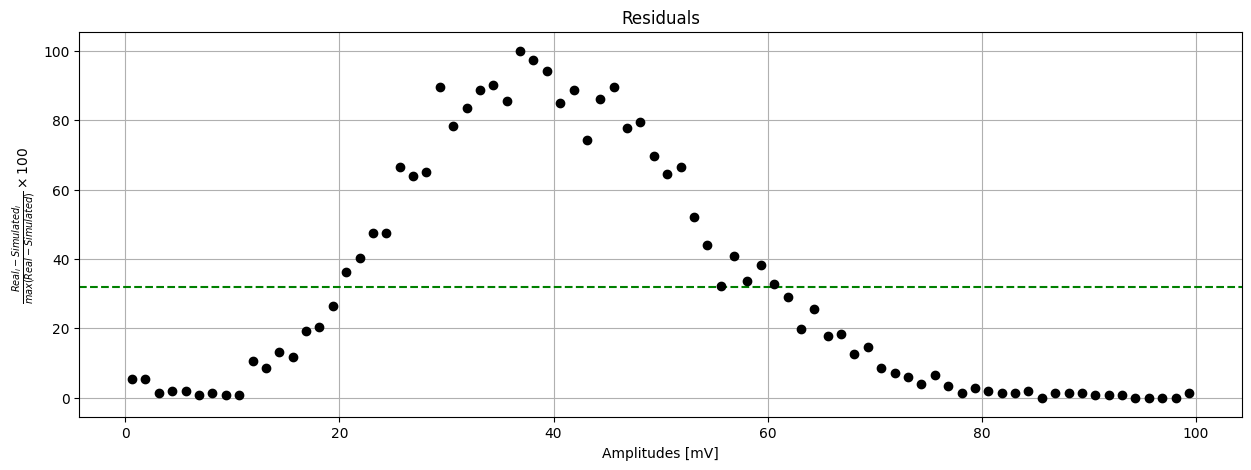

In [419]:
fig = plt.figure(figsize=(15,5))
fig.tight_layout()
plt.errorbar(bin_centers,abs(real-hist)/max(abs(real-hist))*100,final_error/max(abs(real-hist)), fmt='ko')
plt.axhline(np.mean(abs(real-hist)/max(abs(real-hist))*100),0,1,linestyle='--',color='green')
plt.ylabel(r'$\frac{Real_{i}-Simulated_{i}}{max(Real-Simulated)}\times 100$')
plt.xlabel('Amplitudes [mV]')
plt.title('Residuals')
plt.grid()

In [420]:
amps = real-hist
hist_amps, bin_edges_amps = np.histogram(amps, bins=80, density=False)
bin_centers_amps = (bin_edges_amps[:-1] + bin_edges_amps[1:]) / 2

In [421]:
from scipy.optimize import curve_fit
def gauss(x,A,mu,sigma):
    return A*np.exp(-((x-mu)/(np.sqrt(2)*sigma))**2)
pin = [100,38,20]

In [430]:
popt, pcov = curve_fit(gauss,bin_centers_amps,amps,pin)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Counts')

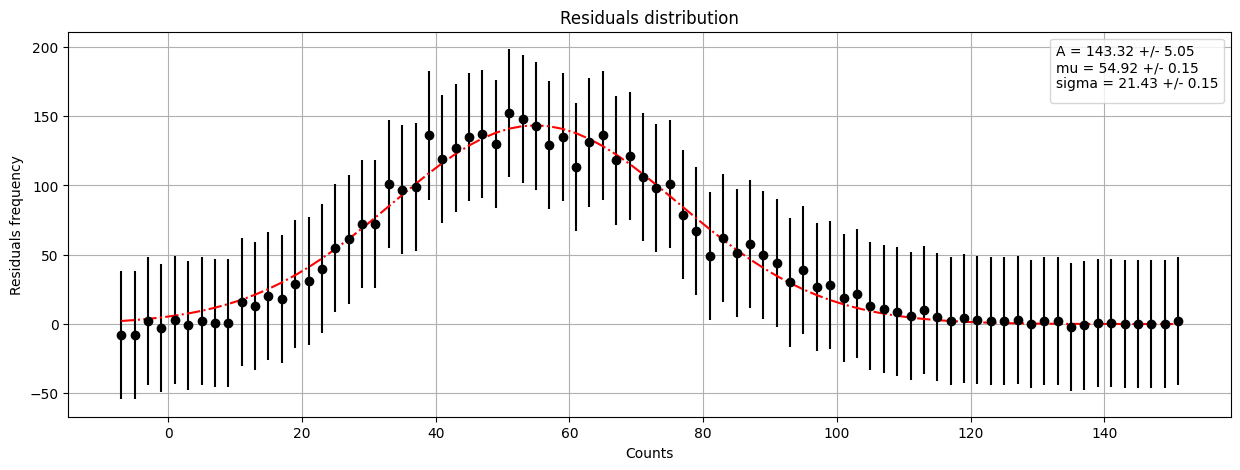

In [431]:
fig = plt.figure(figsize=(15,5))
fig.tight_layout()
plt.errorbar(bin_centers_amps,amps,final_error/max(abs(real-hist))*100,fmt='ko')
plt.plot(bin_centers_amps,gauss(bin_centers_amps, *popt),linestyle='-.',color='red')
text = [
    f'A = {popt[0]:.2f} +/- {np.diag(pcov)[0]:.2f}',
    f'mu = {popt[1]:.2f} +/- {np.diag(pcov)[1]:.2f}',
    f'sigma = {popt[2]:.2f} +/- {np.diag(pcov)[2]:.2f}'
]
plt.legend(title="\n".join(text),fontsize=10)
plt.title('Residuals distribution')
plt.grid()
plt.ylabel('Residuals frequency')
plt.xlabel('Counts')

In [455]:
import numpy as np
from scipy.optimize import minimize

def calculate_skewness(lambda_, E, k=3e-5):
    term = k**2 + lambda_ * E**2
    if term <= 0:
        return np.nan  # Avoid invalid calculations
    return (E**3 * lambda_) / (term ** (3/2))

def objective_function(params):
    lambda_, E = params
    target_skewness = 1.2
    skewness = calculate_skewness(lambda_, E)
    return abs(skewness - target_skewness)

# Initial guesses for lambda and E
initial_guess = [4, 8*1e-5]

# Boundaries for lambda and E to prevent invalid values
bounds = [(1, 20), (1e-5, 1)]

# Perform optimization
result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')

lambda_solution, E_solution = result.x
min_diff = result.fun
target_skewness = 1.2

print(f'Skewness: {min_diff+target_skewness}')
print(f"Best lambda: {lambda_solution:.2f}")
print(f"Best E: {E_solution:.2e}")
print(f"Difference from target skewness: {min_diff:.2e}")
print(f"Difference percentage: {100 * (min_diff / target_skewness):.2f}%")


Skewness: 1.4000000350529889
Best lambda: 1.00
Best E: 1.96e-01
Difference from target skewness: 2.00e-01
Difference percentage: 16.67%
